# 資料增強—隨機裁切

origin image
(720, 960, 3)


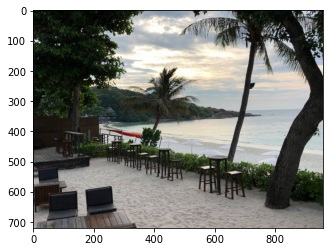

random crop
(300, 200, 3)


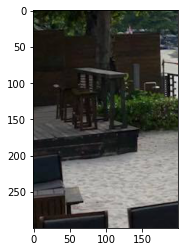

In [2]:
# tf.image.random_crop(raw_image, [300,200,3])
%matplotlib inline
import tensorflow as tf
from PIL import Image  # 讀取影像 pip install pillow
import numpy as np
import matplotlib.pyplot as plt 
raw_image = Image.open('view.jpg')
raw_image = np.asarray(raw_image)
print('origin image')
print(raw_image.shape)
plt.imshow(raw_image)
plt.show()

rand_crop_img = tf.image.random_crop(raw_image, [300,200,3])

print('random crop')
print(rand_crop_img.shape)
plt.imshow(rand_crop_img)
plt.show()

# 資料增強—翻面

origin image
(720, 960, 3)


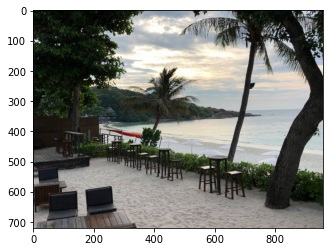

flip
(720, 960, 3)


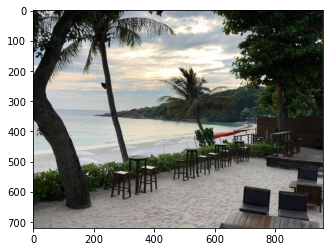

In [3]:
# flip_img = tf.image.random_flip_left_right(raw_image) # 50% will flip image
%matplotlib inline
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
raw_image = Image.open('view.jpg')
raw_image = np.asarray(raw_image)
print('origin image')
print(raw_image.shape)
plt.imshow(raw_image)
plt.show()


flip_img = tf.image.random_flip_left_right(raw_image) # 50% will flip image

print('flip')
print(flip_img.shape)
plt.imshow(flip_img)
plt.show()
        

# 資料增強—調整亮度

origin image
(720, 960, 3)


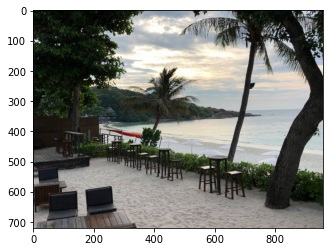

adjust brightness
(720, 960, 3)


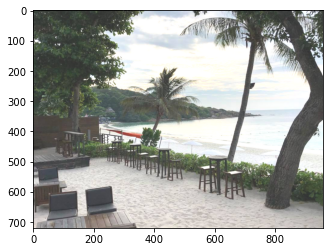

In [4]:
# bright_img = tf.image.adjust_brightness(raw_image, delta= 0.2)
%matplotlib inline
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
raw_image = Image.open('view.jpg')
raw_image = np.asarray(raw_image)
print('origin image')
print(raw_image.shape)
plt.imshow(raw_image)
plt.show()

bright_img = tf.image.adjust_brightness(raw_image, delta= 0.2)

print('adjust brightness')
print(bright_img.shape)
plt.imshow(bright_img)
plt.show()

# VGG13

In [ ]:
import  tensorflow as tf
from    tensorflow.keras import layers, optimizers, datasets, Sequential
import  os

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # 来使得显示什么信息: 1 顯示所有訊息 2只顯示warning ^ error
tf.random.set_seed(2345)

conv_layers = [ # 5 units of conv + max pooling
    # unit 1
    layers.Conv2D(64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.Conv2D(64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),

    # unit 2
    layers.Conv2D(128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.Conv2D(128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),

    # unit 3
    layers.Conv2D(256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.Conv2D(256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),

    # unit 4
    layers.Conv2D(512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.Conv2D(512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),

    # unit 5
    layers.Conv2D(512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.Conv2D(512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same')

]


def preprocess(x, y):
    # [0~1]
    x = 2*tf.cast(x, dtype=tf.float32) / 255.-1 # normalize to -1 to 1 之間
    y = tf.cast(y, dtype=tf.int32)
    return x,y

## tf.squeeze和tf.expand_dims互为逆操作。 tf.squeez 刪除維度是1的
# # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
# # tf.shape(tf.squeeze(t))  # [2, 3]
(x,y), (x_test, y_test) = datasets.cifar10.load_data()
y = tf.squeeze(y, axis=1)
y_test = tf.squeeze(y_test, axis=1)
print(x.shape, y.shape, x_test.shape, y_test.shape)

# tf.data.Dataset.from_tensor_slices 丟到 Dataset 才能 shuffle & batch
train_db = tf.data.Dataset.from_tensor_slices((x,y)) # to Dataset
train_db = train_db.shuffle(1000).map(preprocess).batch(128)

test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_db = test_db.map(preprocess).batch(64)

sample = next(iter(train_db))
print('sample:', sample[0].shape, sample[1].shape,
      tf.reduce_min(sample[0]), tf.reduce_max(sample[0]))


def main():
    # [b, 32, 32, 3] => [b, 1, 1, 512]
    conv_net = Sequential(conv_layers)
    fc_net = Sequential([
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(10, activation=None),
    ])

    conv_net.build(input_shape=[None, 32, 32, 3])
    fc_net.build(input_shape=[None, 512])
    conv_net.summary()
    fc_net.summary()
    optimizer = optimizers.Adam(lr=1e-4)

    # [1, 2] + [3, 4] => [1, 2, 3, 4]
    variables = conv_net.trainable_variables + fc_net.trainable_variables

    for epoch in range(50):
        for step, (x,y) in enumerate(train_db):
            with tf.GradientTape() as tape:
                # [b, 32, 32, 3] => [b, 1, 1, 512]
                out = conv_net(x)
                # flatten, => [b, 512]
                out = tf.reshape(out, [-1, 512])
                # [b, 512] => [b, 10]
                logits = fc_net(out)
                # [b] => [b, 10]
                y_onehot = tf.one_hot(y, depth=10)
                # compute loss
                loss = tf.losses.categorical_crossentropy(y_onehot, logits, from_logits=True)
                loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(grads, variables))

            if step %100 == 0:
                print(epoch, step, 'loss:', float(loss))


        total_num = 0
        total_correct = 0
        for x,y in test_db:
            out = conv_net(x)
            out = tf.reshape(out, [-1, 512])
            logits = fc_net(out)
            prob = tf.nn.softmax(logits, axis=1)
            pred = tf.argmax(prob, axis=1)
            pred = tf.cast(pred, dtype=tf.int32)

            correct = tf.cast(tf.equal(pred, y), dtype=tf.int32)
            correct = tf.reduce_sum(correct)

            total_num += x.shape[0]
            total_correct += int(correct)

        acc = total_correct / total_num
        print(epoch, 'acc:', acc)



if __name__ == '__main__':
    main()


# Resnet18

In [3]:
import  tensorflow as tf
from    tensorflow.keras import layers, optimizers, datasets, Sequential
import  os
from    resnet import resnet18

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.random.set_seed(2345)





def preprocess(x, y):
    # 將數據映射到-1~1
    x = 2*tf.cast(x, dtype=tf.float32) / 255. - 1
    y = tf.cast(y, dtype=tf.int32) # 類型轉換
    return x,y


(x,y), (x_test, y_test) = datasets.cifar10.load_data() # 加載數據集
y = tf.squeeze(y, axis=1) # 刪除不必要的維度
y_test = tf.squeeze(y_test, axis=1) # 刪除不必要的維度
print(x.shape, y.shape, x_test.shape, y_test.shape)


train_db = tf.data.Dataset.from_tensor_slices((x,y)) # 構建訓練集
# 隨機打散，預處理，批量化
train_db = train_db.shuffle(1000).map(preprocess).batch(512)

test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test)) #構建測試集
# 隨機打散，預處理，批量化
test_db = test_db.map(preprocess).batch(512)
# 採樣一個樣本
sample = next(iter(train_db))
print('sample:', sample[0].shape, sample[1].shape,
      tf.reduce_min(sample[0]), tf.reduce_max(sample[0]))


def main():

    # [b, 32, 32, 3] => [b, 1, 1, 512]
    model = resnet18() # ResNet18網絡
    model.build(input_shape=(None, 32, 32, 3))
    model.summary() # 統計網絡參數
    optimizer = optimizers.Adam(lr=1e-4) # 構建優化器

    for epoch in range(30): # 訓練epoch

        for step, (x,y) in enumerate(train_db):

            with tf.GradientTape() as tape:
                # [b, 32, 32, 3] => [b, 10],前向傳播
                logits = model(x)
                # [b] => [b, 10],one-hot編碼
                y_onehot = tf.one_hot(y, depth=10)
                # 計算交叉熵
                loss = tf.losses.categorical_crossentropy(y_onehot, logits, from_logits=True)
                loss = tf.reduce_mean(loss)
            # 計算梯度信息
            grads = tape.gradient(loss, model.trainable_variables)
            # 更新網絡參數
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step %50 == 0:
                print(epoch, step, 'loss:', float(loss))



        total_num = 0
        total_correct = 0
        for x,y in test_db:

            logits = model(x)
            prob = tf.nn.softmax(logits, axis=1)
            pred = tf.argmax(prob, axis=1)
            pred = tf.cast(pred, dtype=tf.int32)

            correct = tf.cast(tf.equal(pred, y), dtype=tf.int32)
            correct = tf.reduce_sum(correct)

            total_num += x.shape[0]
            total_correct += int(correct)

        acc = total_correct / total_num
        print(epoch, 'acc:', acc)



if __name__ == '__main__':
    main()


(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)
sample: (512, 32, 32, 3) (512,) tf.Tensor(-1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 30, 30, 64)        2048      
_________________________________________________________________
sequential_3 (Sequential)    (None, 30, 30, 64)        148736    
_________________________________________________________________
sequential_4 (Sequential)    (None, 15, 15, 128)       526976    
_________________________________________________________________
sequential_6 (Sequential)    (None, 8, 8, 256)         2102528   
_________________________________________________________________
sequential_8 (Sequential)    (None, 4, 4, 512)         8399360   
_________________________________________________________________
global_average_pooling

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


0 0 loss: 2.304671287536621
0 50 loss: 1.723785638809204
0 acc: 0.4091
1 0 loss: 1.5228928327560425
1 50 loss: 1.4037078619003296
1 acc: 0.4805
2 0 loss: 1.3817813396453857
2 50 loss: 1.3430981636047363
2 acc: 0.531
3 0 loss: 1.2128719091415405
3 50 loss: 1.1338651180267334
3 acc: 0.5785
4 0 loss: 1.1563966274261475
4 50 loss: 1.10068678855896
4 acc: 0.6244
5 0 loss: 0.9876735806465149
5 50 loss: 1.0371249914169312
5 acc: 0.6257
6 0 loss: 1.0479137897491455
6 50 loss: 1.003214716911316
6 acc: 0.6091
7 0 loss: 0.9428470134735107
7 50 loss: 0.8433940410614014
7 acc: 0.6771
8 0 loss: 0.846696674823761
8 50 loss: 0.8087090253829956
8 acc: 0.6839
9 0 loss: 0.7179876565933228
9 50 loss: 0.7511836290359497
9 acc: 0.6896
10 0 loss: 0.761368989944458
10 50 loss: 0.8014981150627136
10 acc: 0.7049
11 0 loss: 0.6334070563316345
11 50 loss: 0.6758136749267578
11 acc: 0.7119
12 0 loss: 0.6533529758453369
12 50 loss: 0.7825643420219421
12 acc: 0.7319
13 0 loss: 0.5960507988929749
13 50 loss: 0.501391